In [1]:
# Final Project
# Ellis Lee A92029710
# Kevin Gonzalez A99090166
# Areli Lira A12125926 
# Khoa Bui A12641103
# Alina Chin A13358627
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
from sklearn import preprocessing
from scipy.stats.stats import pearsonr

In [2]:
# Read suicide data.
data = pd.read_csv('suicide.csv')
data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
# Drop country-year variable and rename columns. change gdp to numeric
data = data.drop(['country-year'],axis=1)
data.columns = ['country','year','sex','age','suicides','population',
              '100k_suicides','HDI','gdp','gdp_capita','generation']
data['gdp'] = pd.to_numeric([a['gdp'].replace(',','') for b,a in data.iterrows()])

In [4]:
# We want to find the percentage of the total population for a given group, it might be useful
data['population_est'] = data['population']/(data['gdp']/data['gdp_capita'])

In [5]:
# Summary for the data
data.describe()

,year,suicides,population,100k_suicides,HDI,gdp,gdp_capita,population_est
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,2.782000e+04,27820.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,4.455810e+11,16866.464414,0.083357
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,1.453610e+12,18887.576472,0.040477
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,4.691962e+07,251.000000,0.000892
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,8.985353e+09,3447.000000,0.058681
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,4.811469e+10,9372.000000,0.082433
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,2.602024e+11,24874.000000,0.109253
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,1.812071e+13,126352.000000,0.309876


/Users/kevinice/anaconda2/envs/kevin/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kevinice/anaconda2/envs/kevin/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


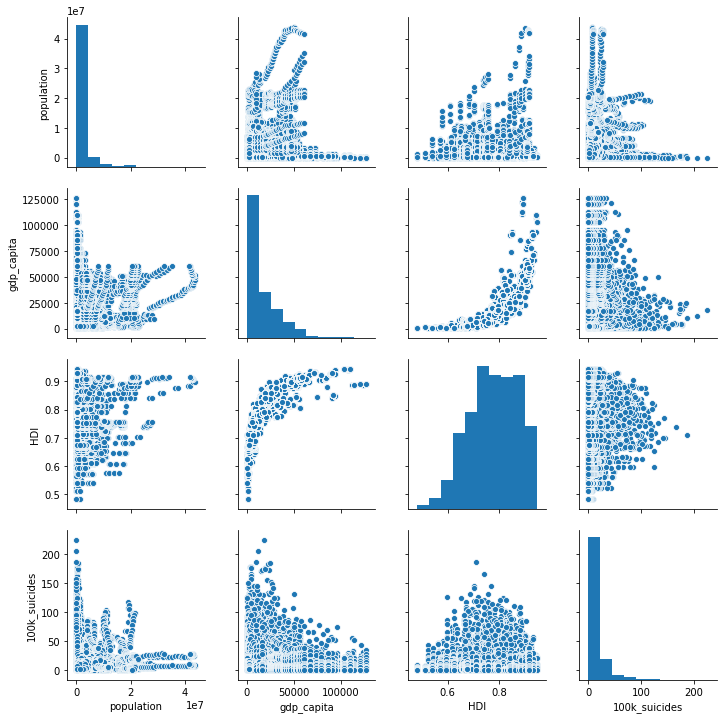

In [6]:
# Correlations of important variables
dat = data[['population','gdp_capita','HDI','100k_suicides']]
sns.pairplot(dat)

In [7]:
# The gdp_capita and HDI plot is the most stricking. There seems to be a strong correlation between happiness
# and the gdp per capita of any given country, and there also seems to be no strong (or any at all) correlation
# between GDP,HDI, or population and suicide rate
print(np.corrcoef(data['gdp_capita'][~np.isnan(data['HDI'])],data['HDI'][~np.isnan(data['HDI'])])[0])

[1.         0.77122783]


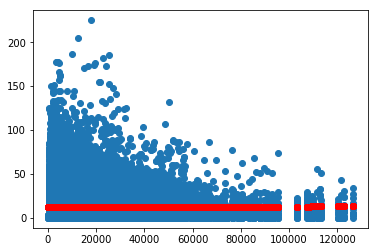

In [8]:
# simple model total suicide and total gdp
a1,a2 = np.polyfit(data['gdp_capita'],data['100k_suicides'],1)
x_vals = data['gdp_capita']
y_vals = a1 * x_vals + a2
plt.scatter(x_vals,data['100k_suicides'])
plt.plot(x_vals,y_vals,'ro' )

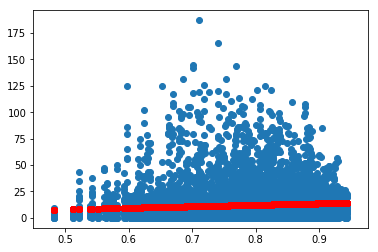

In [9]:
# We can see that suicide rate goes up as GDP goes up, albeit only slightly.
# Lets see how HDI compares to suicide
b1,b2 = np.polyfit(data['HDI'][~np.isnan(data['HDI'])],data['100k_suicides'][~np.isnan(data['HDI'])],1)
x_vals = data['HDI'][~np.isnan(data['HDI'])]
y_vals = b1 * x_vals + b2
plt.scatter(x_vals,data['100k_suicides'][~np.isnan(data['HDI'])])
plt.plot(x_vals,y_vals,'ro' )

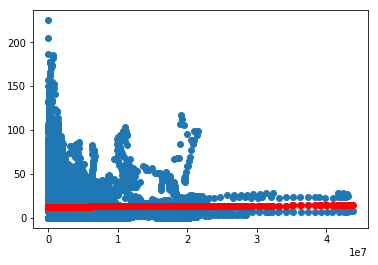

In [10]:
# Again we see a small increase, which is not what one would expect. Lets see how it compares with population
c1,c2 = np.polyfit(data['population'],data['100k_suicides'],1)
x_vals = data['population']
y_vals = c1 * x_vals + c2
plt.scatter(x_vals,data['100k_suicides'])
plt.plot(x_vals,y_vals,'ro' )

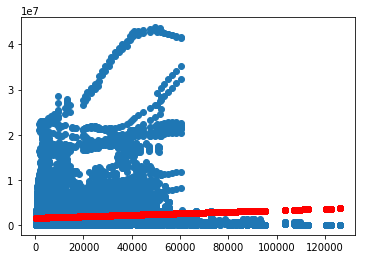

In [11]:
# So maybe bigger populations correlate with bigger gdp or hdi and therefore these two variables
# have positive linear value. Lets plot a linear between gdp_capita and population
c1,c2 = np.polyfit(data['gdp_capita'],data['population'],1)
x_vals = data['gdp_capita']
y_vals = c1 * x_vals + c2
plt.scatter(x_vals,data['population'])
plt.plot(x_vals,y_vals,'ro' )

In [12]:
# Assumptions were correct. Population correlates with higher gdp per capita
# Now lets look at the different descriptors and see how they relate to suicide
# We want to identify at risk groups, and maybe hypothesize why we believe those groups are at risk.
# THis is data preparation for a stackedbarplot
total = pd.DataFrame(data['100k_suicides'].groupby([data['year'],data['generation'],data['sex']]).mean()).reset_index()
#We need to fix some and add counts before (for millenials and gen z we need to add 0s before)
gens = ['Millenials','Generation Z','G.I. Generation']
for g in gens:
    for y in range(1985,2017,1):
        temp = total[(total['generation']==g) & (total['sex']=='male')]['year']
        if int(y) not in np.array(temp):
            total = total.append({'year':int(y),'generation':g,'sex':'male','100k_suicides':0} , ignore_index=True)
        temp = total[(total['generation']==g) & (total['sex']=='female')]['year']
        if int(y) not in np.array(temp):
            total = total.append({'year':int(y),'generation':g,'sex':'female','100k_suicides':0} , ignore_index=True)
#Boomers are missing 2010
totalm = (int(total[(total['generation']=='Boomers') & (total['year']==2009) & (total['sex']=='male')]['100k_suicides']) + 
          int(total[(total['generation']=='Boomers') & (total['year']==2011) & (total['sex']=='male')]['100k_suicides']))/2
total = total.append({'year':2010,'generation':'Boomers','sex':'male','100k_suicides':totalm} , ignore_index=True)
totalf = (int(total[(total['generation']=='Boomers') & (total['year']==2009) & (total['sex']=='female')]['100k_suicides']) + 
         int(total[(total['generation']=='Boomers') & (total['year']==2011) & (total['sex']=='female')]['100k_suicides']))/2
total = total.append({'year':2010,'generation':'Boomers','sex':'female','100k_suicides':totalf} , ignore_index=True)

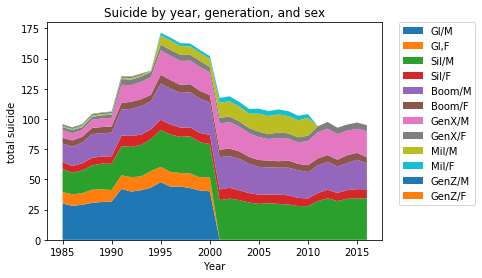

In [13]:
# Lets do a stacked barplot of suicide rate for every generation. 
plt.stackplot(range(1985,2017),total[(total['sex']=='male') & (total['generation']=='G.I. Generation')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='G.I. Generation')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Silent')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Silent')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Boomers')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Boomers')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Generation X')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Generation X')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Millenials')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Millenials')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Generation Z')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Generation Z')]['100k_suicides'],)
plt.title('Suicide by year, generation, and sex')
plt.legend('Generation and sex')
plt.ylabel('total suicide')
plt.xlabel('Year')
plt.legend(['GI/M','GI,F','Sil/M','Sil/F','Boom/M','Boom/F',
            'GenX/M','GenX/F','Mil/M','Mil/F','GenZ/M','GenZ/F'],bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

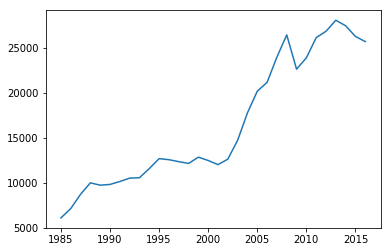

In [14]:
# The first dip (at around 2000) seems to be due to GenZ. It seems like suicide rates went up until 2000,
# but have remained mostly constant after the dip. How much has the mean GPD in the world increased over time?
dat = data[(data['generation']=='Silent') & (data['sex']=='male')]
temp = pd.DataFrame(dat['gdp_capita'].groupby(dat['year']).mean()).reset_index()
plt.plot(range(1985,2017),temp['gdp_capita'])

In [15]:
# So while GDP has increased, suicide did not necessarily go down. One big question is, how has reporting changed?
# Is this data overreporting some years and underreporting others? It is clear from priting the amount of data per year
# That theree has been an uptick in reportin from 2000 to 2010. This makes the data less valuable when analyzing yearly
# trends, since we may have reporting of differen countries per year or enough different to sway results
# one way or the other. This is a limitation of this dataset.
mydict = {}
for i in range(1985,2017):
    mydict[str(i)] = len(dat[dat['year']==i]['gdp_capita'])
mydict   

{'1985': 48,
 '1986': 48,
 '1987': 54,
 '1988': 49,
 '1989': 52,
 '1990': 64,
 '1991': 64,
 '1992': 65,
 '1993': 65,
 '1994': 68,
 '1995': 78,
 '1996': 77,
 '1997': 77,
 '1998': 79,
 '1999': 83,
 '2000': 86,
 '2001': 176,
 '2002': 172,
 '2003': 172,
 '2004': 168,
 '2005': 168,
 '2006': 170,
 '2007': 172,
 '2008': 170,
 '2009': 178,
 '2010': 176,
 '2011': 86,
 '2012': 81,
 '2013': 80,
 '2014': 78,
 '2015': 62,
 '2016': 16}

In [16]:
# Lets fit a linear model and see which generations and age groups are at higher risk
total1 = pd.DataFrame(data['100k_suicides'].groupby([data['year'],data['generation'],data['sex']]).mean()).reset_index()
total2 = pd.get_dummies(total1)
#total2.drop(['sex_male','generation_Generation Z'], axis=1)
total2.columns = total2.columns.str.replace(' ', '')
total2.columns = total2.columns.str.replace('.', '')
total2.loc[:,'100k_suicides'] = (total2['100k_suicides']-np.mean(total2['100k_suicides']))/np.std(total2['100k_suicides'])
total2.columns = total2.columns.str.replace('100k_suicides', 'target')
a = 'target ~ ' + ' + '.join(total2.columns[2:])
outcome_1, predictors_1 = patsy.dmatrices(a,total2)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     173.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           4.24e-92
Time:                        12:53:35   Log-Likelihood:                -189.79
No. Observations:                 292   AIC:                             393.6
Df Residuals:                     285   BIC:                             419.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [17]:
# Males have a higher suicide rate.
# Older generations had a higher suicide rate. We would like to know if this is a cohort effect or an age effect
total1 = pd.DataFrame(data['100k_suicides'].groupby([data['year'],data['sex'],data['age']]).mean()).reset_index()
total2 = pd.get_dummies(total1)
total2.head()
total2.columns = total2.columns.str.replace(' ', '')
total2.columns = total2.columns.str.replace('.', '')
total2.columns = total2.columns.str.replace('-', 'to')
total2.columns = total2.columns.str.replace('years', '')
total2.columns = total2.columns.str.replace('+', '')
total2.loc[:,'100k_suicides'] = (total2['100k_suicides']-np.mean(total2['100k_suicides']))/np.std(total2['100k_suicides'])
total2.columns = total2.columns.str.replace('100k_suicides', 'target')
a = 'target ~ ' + ' + '.join(total2.columns[2:])
outcome_2, predictors_2 = patsy.dmatrices(a,total2)
mod_2 = sm.OLS(outcome_2,predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     297.0
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          4.21e-139
Time:                        12:53:36   Log-Likelihood:                -207.88
No. Observations:                 382   AIC:                             429.8
Df Residuals:                     375   BIC:                             457.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0034      0.013     -0.262      0.7

In [18]:
# We can't know for sure if this is an age effect or a cohort effect, since thtis data only goes for 30 years.
# This mean it is not long enough to be considered some sort of quasi longitudinal study, and this is more closely
# related to a cohort effect. We can't safely say this is an age effect or a cohort effect, but we can safely say
# Suicide rate is higher the older the generation, but can't say it is because they're older

In [19]:
# In our initial proposal, we thought to examine specific inidicators in Canada
# We decided to examine this indicators on the whole dataset since we were able to merge it
# successfully
dat = pd.read_csv('Data.csv')
dat.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,...,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,Arab World,ARB,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# We will focus only on these variables in the shortlist from all the indices. This was mostly because
# Most of the indices available that matched both countries 
shortlist = ["Improved water source, urban (% of urban population with access)","Immunization, measles (% of children ages 12-23 months)",
             "School enrollment, primary (% gross)","Mortality rate, infant (per 1,000 live births)",
             "Adolescent fertility rate (births per 1,000 women ages 15-19)","Mortality rate, neonatal (per 1,000 live births)"]
replacements = ['water','measles','enrollment','mortality','adolescence','birth']
remove = ['Country Code','Indicator Code','1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', 
 '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983','1984']
dat1 = dat[dat['Indicator Name'].isin(shortlist)]
dat1 = dat1.drop(remove, axis=1)
dat1 = dat1[dat1.isnull().sum(axis=1)<10]

In [21]:
# We append it to the list
countrylist = np.unique([e for e in np.unique(dat1['Country Name']) if e in '\n'.join(np.unique(data['country']))])
for i, row in dat1.iterrows():
    string = row['Indicator Name']
    if row['Country Name'] in countrylist:
        val = replacements[shortlist.index(string)]
        for i in range(1985,2016):
            if str(val) not in data.columns:
                data[str(val)] = np.nan
            data.loc[((data['country'] == row['Country Name']) & (data['year']==int(i))),[str(val)]] = row[str(i)]
data.head()

,country,year,sex,age,suicides,population,100k_suicides,HDI,gdp,gdp_capita,generation,population_est,adolescence,measles,water,mortality,birth,enrollment
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,2156624900,796,Generation X,0.115490,16.342,96.0,NaN,40.8,NaN,101.758659
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,2156624900,796,Silent,0.113681,16.342,96.0,NaN,40.8,NaN,101.758659
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,2156624900,796,Generation X,0.106927,16.342,96.0,NaN,40.8,NaN,101.758659
3,Albania,1987,male,75+ years,1,21800,4.59,NaN,2156624900,796,G.I. Generation,0.008046,16.342,96.0,NaN,40.8,NaN,101.758659
4,Albania,1987,male,25-34 years,9,274300,3.28,NaN,2156624900,796,Boomers,0.101243,16.342,96.0,NaN,40.8,NaN,101.758659


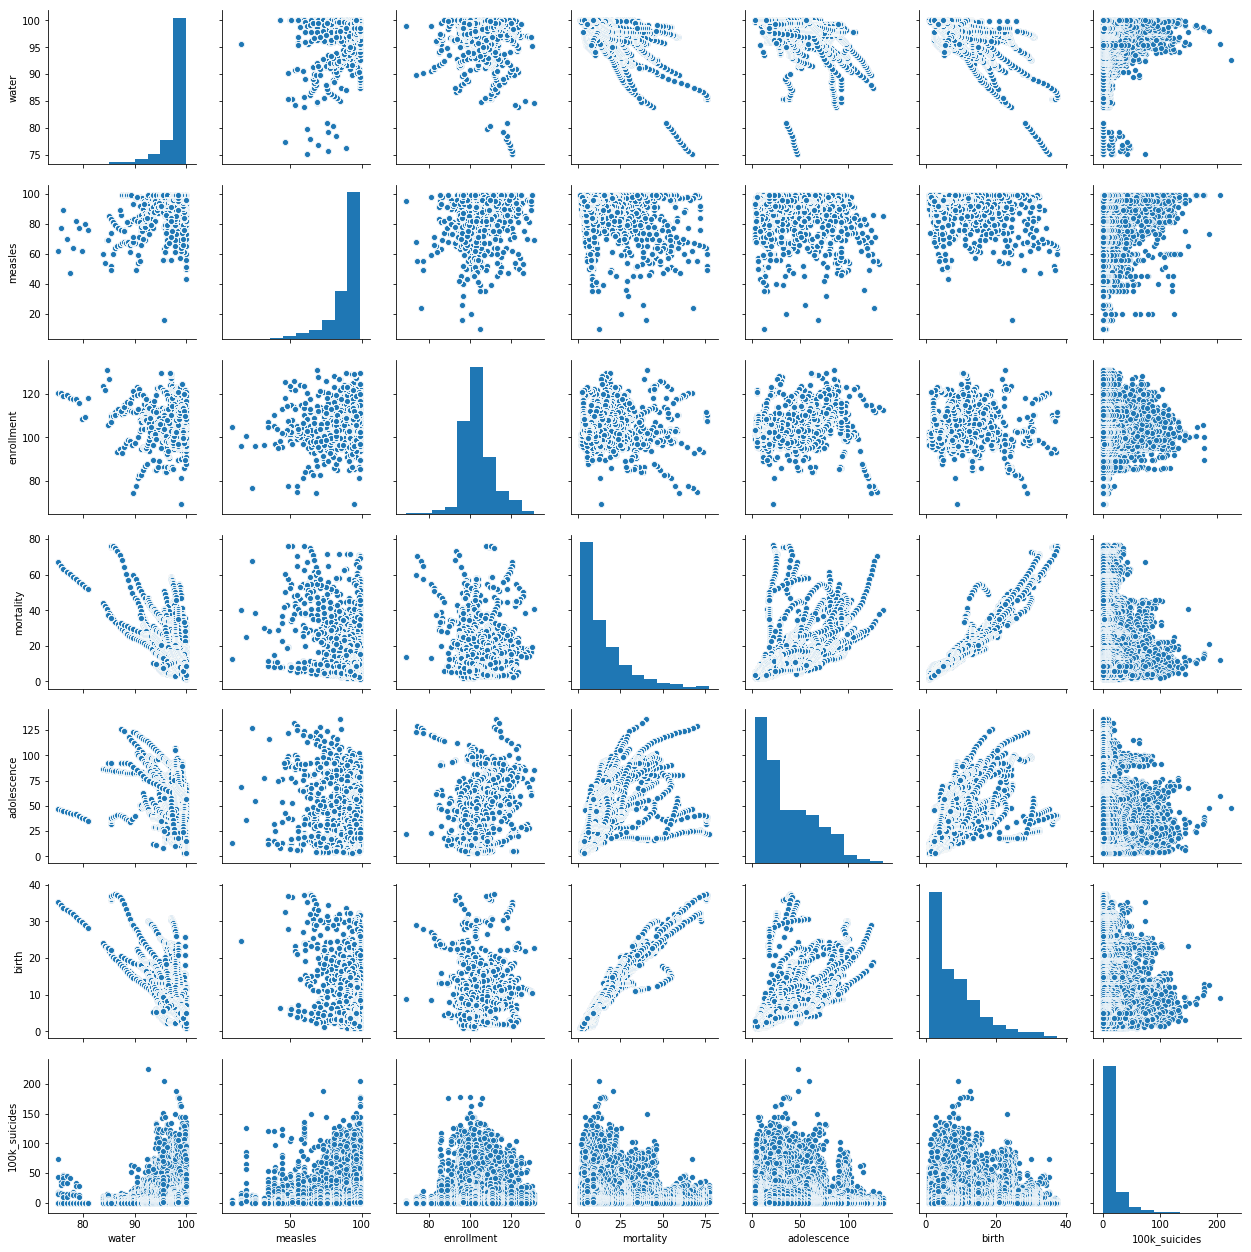

In [22]:
# Correlations between all the variables
pairplot = replacements + ['100k_suicides']
finaldat = data[pairplot]
sns.pairplot(finaldat)

In [24]:
# morality and water availability seem to be heavily correlated with each other, No big correlations with suicide
data.loc[:,'100k_suicides'] = (data['100k_suicides']-np.mean(data['100k_suicides']))/np.std(data['100k_suicides'])
data.columns = data.columns.str.replace('100k_suicides', 'target')
a = 'target ~' + ' + '.join(replacements)
outcome_3, predictors_3 = patsy.dmatrices(a,data)
mod_3 = sm.OLS(outcome_3,predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     106.7
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          1.41e-132
Time:                        12:59:27   Log-Likelihood:                -24675.
No. Observations:               17340   AIC:                         4.936e+04
Df Residuals:                   17333   BIC:                         4.942e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.5301      0.395     -3.873      

In [ ]:
# What our results show is that there is no one solution for suicide. This is a hollistic issue where many variables
# Can play a small role.